In [0]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation, Dense, Lambda, Input, MaxPooling2D, Dropout, Flatten, Reshape, UpSampling2D, Concatenate
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from keras.utils import plot_model, to_categorical

In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1, 784)).astype('float32') / 255.0
x_test = x_test.reshape((-1, 784)).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# ENCODER

In [0]:
image_shape = (28, 28, 1)
original_dim = image_shape[0] * image_shape[1]
input_shape = (original_dim,)
batch_size = 128
latent_dim = 4
epochs = 50

# encoder
inputs = Input(shape=input_shape)
x = Reshape(image_shape)(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 28, 28, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         reshape_4[0][0]                  
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_5[0][0]                   
____________________________________________________________________________________________

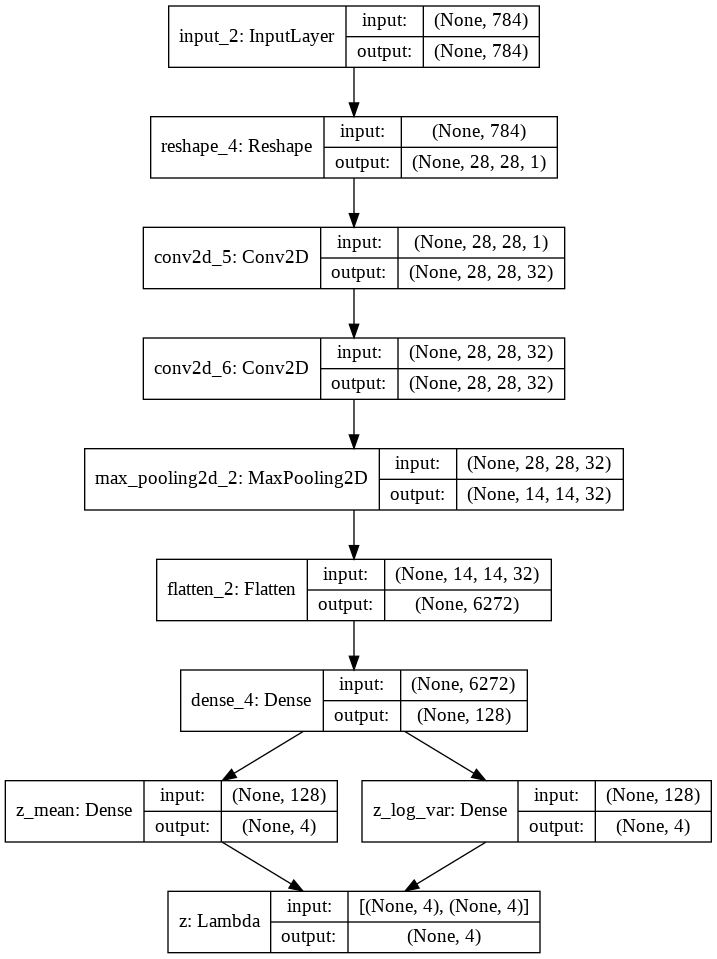

In [18]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, show_shapes=True)

# DECODER

In [0]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
label_inputs = Input(shape=(10,), name='label')
x = Concatenate()([latent_inputs, label_inputs])
x = Dense(128, activation='relu')(x)
x = Dense(14 * 14 * 32, activation='relu')(x)
x = Reshape((14, 14, 32))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
outputs = Reshape(input_shape)(x)

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_sampling (InputLayer)         (None, 4)            0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 14)           0           z_sampling[0][0]                 
                                                                 label[0][0]                      
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          1920        concatenate_2[0][0]        

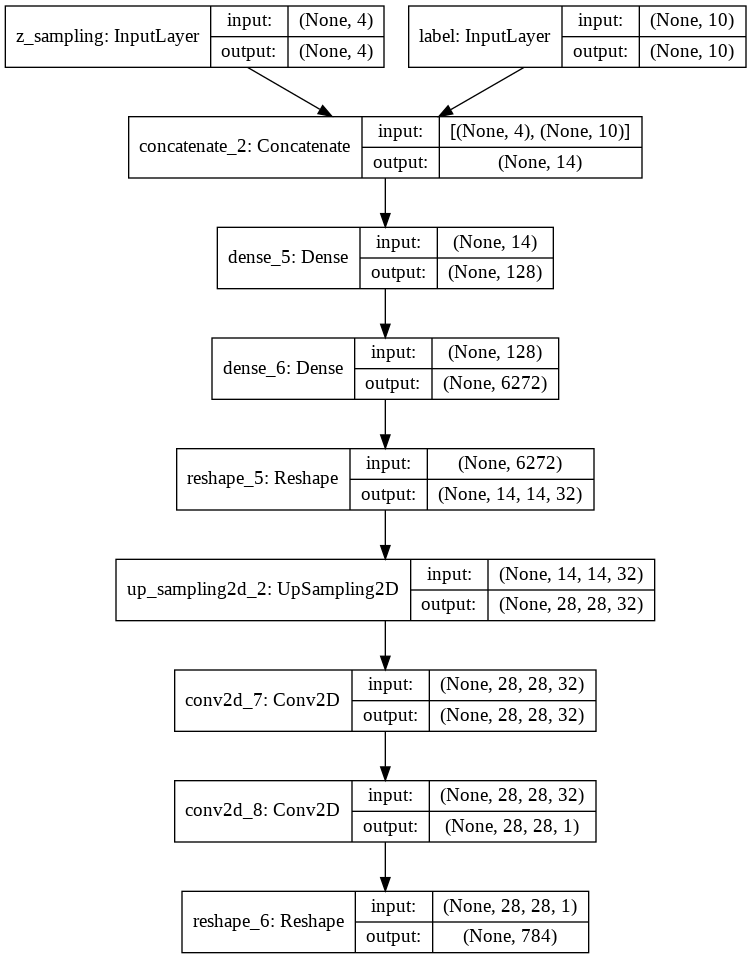

In [20]:
decoder = Model([latent_inputs, label_inputs], outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)


Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 813544      input_2[0][0]                    
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          820545      encoder[1][2]                    
                                                                 label[0][0]                

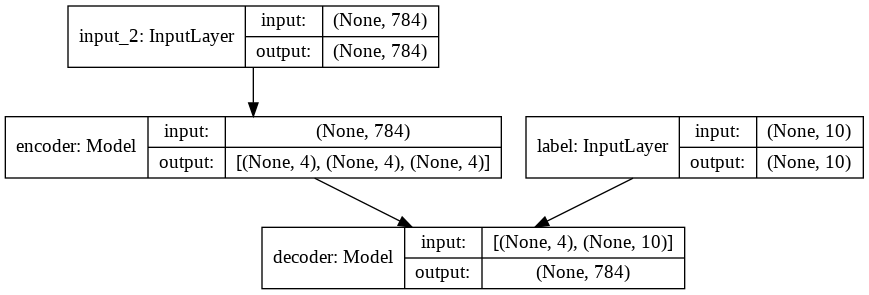

In [21]:
outputs = decoder([encoder(inputs)[2], label_inputs])
vae = Model([inputs, label_inputs], outputs, name='vae_mlp')
vae.summary()
plot_model(vae, show_shapes=True)

In [0]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [23]:
vae.fit([x_train, y_train],epochs=epochs,batch_size=batch_size,validation_data=([x_test, y_test], None))
vae.save('vae_cnn_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 18s 294us/step - loss: 38.3945 - val_loss: 30.4518
Epoch 2/50
60000/60000 [==============================] - 17s 280us/step - loss: 29.7183 - val_loss: 28.9161
Epoch 3/50
60000/60000 [==============================] - 17s 279us/step - loss: 28.6172 - val_loss: 28.3276
Epoch 4/50
60000/60000 [==============================] - 17s 279us/step - loss: 28.0747 - val_loss: 27.8202
Epoch 5/50
60000/60000 [==============================] - 17s 280us/step - loss: 27.6875 - val_loss: 27.5194
Epoch 6/50
60000/60000 [==============================] - 17s 281us/step - loss: 27.4387 - val_loss: 27.3029
Epoch 7/50
60000/60000 [==============================] - 17s 280us/step - loss: 27.2314 - val_loss: 27.2112
Epoch 8/50
60000/60000 [==============================] - 17s 280us/step - loss: 27.0580 - val_loss: 27.0753
Epoch 9/50
60000/60000 [==============================] - 17s 280us/step - los

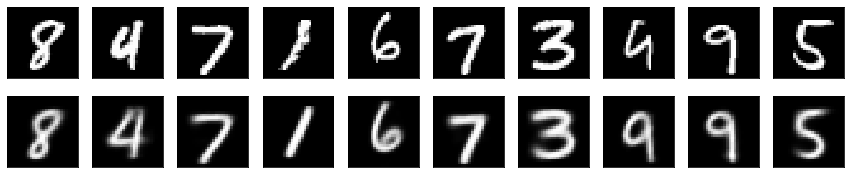

In [27]:
fig, axes = plt.subplots(2, 10, figsize=(15, 3))

def show(im):
    plt.imshow(im.reshape((28, 28)), cmap='gray')
    #sns.heatmap(im.reshape((28, 28)), cmap='Greys', cbar=False, square=True, )

sample = np.random.randint(len(x_test), size=10)
reconst = vae.predict([x_test[sample], y_test[sample]])

for i in range(10):
    axes[0, i].get_xaxis().set_visible(False)
    axes[0, i].get_yaxis().set_visible(False)
    plt.sca(axes[0, i])
    show(x_test[sample[i]])
    axes[1, i].get_xaxis().set_visible(False)
    axes[1, i].get_yaxis().set_visible(False)
    plt.sca(axes[1, i])
    show(reconst[i])

plt.show()